# Recommend movies using Matrix Factorization with Gluon

In [1]:
import os
import mxnet as mx
from mxnet import gluon, nd, ndarray

import pandas as pd
import numpy as np

/Users/sssokolo/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Parameters

In [2]:
data_path = '/tmp/ml-100k/'
prefix='ml-100k'
num_emb = 64
opt = 'sgd'
lr = 0.02
mmntm = 0.
wd = 0.
batch_size = 50
ctx = mx.cpu()

# Download and Unpack MovieLens Dataset

In [3]:
def download_ml_data(prefix, os_path):
    if not os.path.exists(os_path+"%s.zip" % prefix):
        print("Downloading MovieLens data: %s" % prefix)
        os.system("wget http://files.grouplens.org/datasets/movielens/{}.zip -P {}".format(prefix, data_path))
    print("unzip {}{}.zip -d {}".format(data_path,prefix, data_path))
    os.system("unzip {}{}.zip -d {}".format(data_path,prefix, data_path))   


download_ml_data(prefix=prefix, os_path=data_path)

unzip /tmp/ml-100k/ml-100k.zip -d /tmp/ml-100k/


# Find Max UserID and Max ItemID

In [4]:
def max_id(fname):
    mu = 0
    mi = 0
    with open(fname) as f:
        for line in f:
            tks = line.strip().split('\t')
            if len(tks) != 4:
                continue
            mu = max(mu, int(tks[0]))
            mi = max(mi, int(tks[1]))
    return mu + 1, mi + 1

max_users, max_items = max_id(data_path + prefix  +'/u.data')
print('Total users: {}. Total items: {}'.format(max_users, max_items))

Total users: 944. Total items: 1683


# Converting Data to NDArray

Dataset u1.base and u1.test are training and test sets of all data. Each row is: user_id, movie_id, rating, timestamp.

In [5]:
train_df = pd.read_csv(data_path + prefix + '/u1.base', header=None, sep='\t')
test_df = pd.read_csv(data_path + prefix + '/u1.test', header=None, sep='\t')

train_data = nd.array(train_df[[0,1]].values, dtype=np.float32)
train_label = nd.array(train_df[2].values, dtype=np.float32)

test_data = nd.array(test_df[[0,1]].values, dtype=np.float32)
test_label = nd.array(test_df[2].values, dtype=np.float32)

print(train_df[0:5])
(train_data[0:5], train_label[0:5])

   0  1  2          3
0  1  1  5  874965758
1  1  2  3  876893171
2  1  3  4  878542960
3  1  4  3  876893119
4  1  5  3  889751712


(
 [[1. 1.]
  [1. 2.]
  [1. 3.]
  [1. 4.]
  [1. 5.]]
 <NDArray 5x2 @cpu(0)>, 
 [5. 3. 4. 3. 3.]
 <NDArray 5 @cpu(0)>)

# Creating Dataset

In [6]:
class SparseMatrixDataset(gluon.data.Dataset):
    def __init__(self, data, label):
        assert data.shape[0] == len(label)
        self.data = data
        self.label = label
        if isinstance(label, ndarray.NDArray) and len(label.shape) == 1:
            self._label = label.asnumpy()
        else:
            self._label = label       
        
    def __getitem__(self, idx):
        return self.data[idx, 0], self.data[idx, 1], self.label[idx]
    
    def __len__(self):
        return self.data.shape[0]
        

# Defining the Network

In [7]:
class MFBlock(gluon.HybridBlock):
    def __init__(self, max_users, max_items, num_emb, dropout_p=0.5):
        super(MFBlock, self).__init__()
        
        self.max_users = max_users
        self.max_items = max_items
        self.dropout_p = dropout_p
        self.num_emb = num_emb
        
        with self.name_scope():
            self.user_embeddings = gluon.nn.Embedding(max_users, num_emb)
            self.item_embeddings = gluon.nn.Embedding(max_items, num_emb)
            self.dropout = gluon.nn.Dropout(dropout_p)
            self.dense = gluon.nn.Dense(num_emb, activation='relu')
            
    def hybrid_forward(self, F, users, items):
        a = self.user_embeddings(users)
        a = self.dense(a)
        
        b = self.item_embeddings(items)
        b = self.dense(b)

        predictions = self.dropout(a) * self.dropout(b)      
        predictions = F.sum(predictions, axis=1)
        return predictions

        

# Creating Network

In [8]:
net = MFBlock(max_users=max_users, max_items=max_items, num_emb=num_emb, dropout_p=0.)
net.collect_params()

mfblock0_ (
  Parameter mfblock0_embedding0_weight (shape=(944, 64), dtype=float32)
  Parameter mfblock0_embedding1_weight (shape=(1683, 64), dtype=float32)
  Parameter mfblock0_dense0_weight (shape=(64, 0), dtype=float32)
  Parameter mfblock0_dense0_bias (shape=(64,), dtype=float32)
)

/Users/sssokolo/anaconda3/lib/python3.6/site-packages/mxnet/visualization.py:292: RuntimeWarning: There are multiple variables with the same name in your graph, this may result in cyclic graph. Repeated names: mfblock0_dropout0_fwd,mfblock0_dense0_fwd,mfblock0_dense0_relu_fwd
  warnings.warn(warning_message, RuntimeWarning)


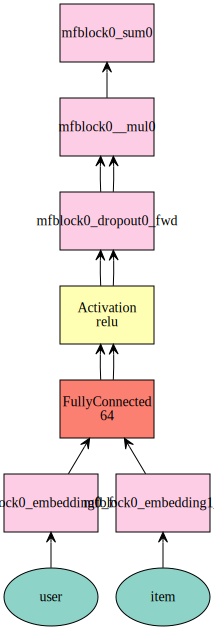

In [9]:
input_sym1 = mx.sym.var('user')
input_sym2 = mx.sym.var('item')
output_sym = net(input_sym1, input_sym2)
mx.viz.plot_network(output_sym, )

# Loss Function

In [10]:
loss_function = gluon.loss.L2Loss()

# Initializer

In [11]:
net.collect_params().initialize(mx.init.Xavier(magnitude=2.24), ctx=ctx, force_reinit=True)

# Optimizer

In [12]:
trainer = gluon.Trainer(net.collect_params(), opt,
                        {'learning_rate': lr, 'wd': wd, 'momentum': 0.9})

# DataLoader

In [13]:
train_data_iter = gluon.data.DataLoader(SparseMatrixDataset(train_data, train_label), 
                                        shuffle=True, batch_size=batch_size)
test_data_iter = gluon.data.DataLoader(SparseMatrixDataset(test_data, test_label),
                                          shuffle=True, batch_size=batch_size)

# Network Evaluator

In [14]:
def eval_net(data, net):
    accs = [mx.metric.RMSE(), mx.metric.Accuracy()]
    acc = mx.metric.CompositeEvalMetric()
    for i in accs:
        acc.add(i)
    for i, (user, item, label) in enumerate(data):
        user = user.as_in_context(ctx).reshape((batch_size,))
        item = item.as_in_context(ctx).reshape((batch_size,))
        label = label.as_in_context(ctx).reshape((batch_size,))
        predictions = net(user, item)
        loss = loss_function(predictions, label)
        acc.update(preds=predictions, labels=label)
    return acc

# Training

In [15]:
epochs = 5

def train(data_iter, net):
    for e in range(epochs):
        print("epoch: {}".format(e))
        for i, (user, item, label) in enumerate(train_data_iter):
            user = user.as_in_context(ctx).reshape((batch_size,))
            item = item.as_in_context(ctx).reshape((batch_size,))
            label = label.as_in_context(ctx).reshape((batch_size,))
            with mx.autograd.record():
                output = net(user, item)               
                loss = loss_function(output, label)
                loss.backward()
            net.collect_params().values()
            trainer.step(batch_size)
        print("EPOCH {}: RMSE ON TRAINING and TEST: {}. {}".format(e,
                                                                   eval_net(train_data_iter, net),
                                                                   eval_net(test_data_iter, net)))
    return "end of training"

In [16]:
train(train_data_iter, net)

epoch: 0
EPOCH 0: RMSE ON TRAINING and TEST: EvalMetric: {'rmse': 0.9392852280661463, 'accuracy': 0.3504875}. EvalMetric: {'rmse': 0.9784612037241459, 'accuracy': 0.33805}
epoch: 1
EPOCH 1: RMSE ON TRAINING and TEST: EvalMetric: {'rmse': 0.9231046421080827, 'accuracy': 0.33245}. EvalMetric: {'rmse': 0.9639356683194638, 'accuracy': 0.32335}
epoch: 2
EPOCH 2: RMSE ON TRAINING and TEST: EvalMetric: {'rmse': 0.9361719639226794, 'accuracy': 0.3702625}. EvalMetric: {'rmse': 0.97912513256073, 'accuracy': 0.35585}
epoch: 3
EPOCH 3: RMSE ON TRAINING and TEST: EvalMetric: {'rmse': 0.9158426959812641, 'accuracy': 0.3394625}. EvalMetric: {'rmse': 0.9589316019415856, 'accuracy': 0.3311}
epoch: 4
EPOCH 4: RMSE ON TRAINING and TEST: EvalMetric: {'rmse': 0.91513403121382, 'accuracy': 0.306575}. EvalMetric: {'rmse': 0.9559863702952862, 'accuracy': 0.30125}


'end of training'

In [23]:
def recommend_k_items_for_user(user_id, k=10):
    all_user = [1] * max_items
    all_items = list(range(1, max_items + 1))
    output = net(mx.nd.array(all_user), mx.nd.array(all_items))
    predictions = mx.nd.topk(output, k=k, is_ascend=False) + 1
    return predictions

In [24]:
recommend_k_items_for_user(10)


[169. 408. 318. 357. 483. 127.  12. 174. 480. 313.]
<NDArray 10 @cpu(0)>